In [ ]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import re


In [1]:
BINARY_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_binary/"
SCORE_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_score/"

In [2]:
def load_results(dataset_name, directory):
    """
    Load the detection results from a given directory for the specified dataset.
    
    Args:
        dataset_name (str): The name of the dataset.
        directory (str): The directory containing the results.
        
    Returns:
        dict: The loaded results.
    """
    filepath = os.path.join(directory, dataset_name)
    with open(filepath, "r") as f:
        return json.load(f)



In [3]:
def extract_metrics(results):
    """
    Extract the metrics (precision, recall, F1, accuracy) from the results.
    
    Args:
        results (dict): The results object containing the metrics.
        
    Returns:
        dict: A dictionary of extracted metrics.
    """
    return {
        "Precision": results["metrics"]["precision"],
        "Recall": results["metrics"]["recall"],
        "F1": results["metrics"]["f1"],
        "Accuracy": results["metrics"]["accuracy"]
    }


In [4]:
import pandas as pd

def extract_confusion(results):
    """
    Extract and format the confusion matrix from the results,
    padding it to 2x2 if necessary.
    
    Args:
        results (dict): The results object containing the confusion matrix.
        
    Returns:
        pd.DataFrame: A 2x2 DataFrame representing the confusion matrix.
    """
    matrix = results["metrics"]["confusion_matrix"]

    # Pad to 2 rows
    while len(matrix) < 2:
        matrix.append([0] * len(matrix[0]))

    # Pad each row to 2 columns
    for i in range(len(matrix)):
        while len(matrix[i]) < 2:
            matrix[i].append(0)

    return pd.DataFrame(matrix,
                        index=["Actual: 0", "Actual: 1"],
                        columns=["Pred: 0", "Pred: 1"])


In [5]:
def get_dataset_names(directory):
    return os.listdir(directory)

# Dataset names to compare across models
binary_dataset_names = get_dataset_names(BINARY_RESULTS_DIR)
score_dataset_names = get_dataset_names(SCORE_RESULTS_DIR)

print(binary_dataset_names)
print(score_dataset_names)



NameError: name 'os' is not defined

In [ ]:
# Initialize empty lists for storing metrics and confusion matrices
binary_metrics = []
score_metrics = []
binary_confusion = []
score_confusion = []

# Loop through each dataset and load results
for dataset_name in tqdm(binary_dataset_names, desc="Processing datasets"):
    # Load results from binary detection
    binary_results = load_results(dataset_name, BINARY_RESULTS_DIR)
    binary_metrics_dict = extract_metrics(binary_results)
    binary_confusion_matrix = extract_confusion(binary_results)
    binary_metrics.append(binary_metrics_dict)
    binary_confusion.append(binary_confusion_matrix)
    





Processing datasets: 100%|██████████| 10/10 [00:00<00:00, 2187.61it/s]


In [ ]:
for dataset_name in tqdm(score_dataset_names, desc="Processing datasets"):
# Load results from score-based detection
    score_results = load_results(dataset_name, SCORE_RESULTS_DIR)
    score_metrics_dict = extract_metrics(score_results)
    score_confusion_matrix = extract_confusion(score_results)
    
    # Append results to lists
    score_metrics.append(score_metrics_dict)
    score_confusion.append(score_confusion_matrix)


Processing datasets: 100%|██████████| 10/10 [00:00<00:00, 2789.32it/s]


In [ ]:
def extract_core_name(dataset_names):
   
    if dataset_names.startswith("ai_interaction_results_"):
        dataset_names = dataset_names[len("ai_interaction_results_"):]
    if dataset_names.endswith("_detection_results"):
        dataset_names = dataset_names[: -len("_detection_results")]
    return dataset_names

formatted_binary_names = [extract_core_name(name) for name in binary_dataset_names]
formatted_score_names = [extract_core_name(name) for name in score_dataset_names]

print(formatted_binary_names)
print(formatted_score_names)

# Convert metrics and confusion matrices into DataFrames
binary_metrics_df = pd.DataFrame(binary_metrics, index=formatted_binary_names)
score_metrics_df = pd.DataFrame(score_metrics, index=formatted_score_names)


['llama3.3-70b_1_interactions_plan_detection_results.json', 'deepseek-chat_1_interactions_plan_detection_results.json', 'gemini-2.0-flash_1_interactions_plan_detection_results.json', 'llama3.3-70b_1_interactions_noplan_detection_results.json', 'gemini-2.0-flash_1_interactions_noplan_detection_results.json', 'deepseek-chat_0_interactions_noplan_detection_results.json', 'llama3.3-70b_0_interactions_noplan_detection_results.json', 'gemini-2.0-flash_0_interactions_noplan_detection_results.json', 'gemini-2.0-flash_0_interactions_plan_detection_results.json', 'deepseek-chat_1_interactions_noplan_detection_results.json']
['llama3.3-70b_1_interactions_plan_detection_results.json', 'deepseek-chat_1_interactions_plan_detection_results.json', 'gemini-2.0-flash_1_interactions_plan_detection_results.json', 'llama3.3-70b_1_interactions_noplan_detection_results.json', 'gemini-2.0-flash_1_interactions_noplan_detection_results.json', 'deepseek-chat_0_interactions_noplan_detection_results.json', 'llama3

In [ ]:
def convert_confusion_matrix_to_metrics(cm):
    """
    Convert confusion matrix to DataFrame with TP, FP, FN, TN
    
    Args:
        cm (list or numpy array): Confusion matrix 
    
    Returns:
        pd.DataFrame: DataFrame with classification metrics
    """
    # Ensure cm is a list or numpy array
    cm = np.array(cm)
    
    # Check if cm is a 2D array
    if cm.ndim != 2 or cm.shape != (2, 2):
        raise ValueError(f"Confusion matrix must be a 2x2 array, got shape {cm.shape}")
    
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'FN': [fn],
        'TN': [tn]
    })
    
    return metrics_df

# Ensure you have the necessary imports
import numpy as np
import pandas as pd

# Print out the structure of binary_confusion to understand its content
print("Type of binary_confusion:", type(binary_confusion))
print("Length of binary_confusion:", len(binary_confusion))
print("First few items of binary_confusion:", binary_confusion[:2])

# Modify the concatenation to handle potential nested structures
binary_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in binary_confusion
], axis=0, keys=formatted_binary_names)

binary_confusion_df = binary_confusion_df.reset_index(level=1, drop=True)
print(binary_confusion_df)

Type of binary_confusion: <class 'list'>
Length of binary_confusion: 10
First few items of binary_confusion: [           Pred: 0  Pred: 1
Actual: 0       96        0
Actual: 1        3        1,            Pred: 0  Pred: 1
Actual: 0       84        0
Actual: 1        5       11]
                                                    TP  FP  FN   TN
llama3.3-70b_1_interactions_plan_detection_resu...   1   0   3   96
deepseek-chat_1_interactions_plan_detection_res...  11   0   5   84
gemini-2.0-flash_1_interactions_plan_detection_...   0   0   4   96
llama3.3-70b_1_interactions_noplan_detection_re...  14   0   2   84
gemini-2.0-flash_1_interactions_noplan_detectio...   6   0  10   84
deepseek-chat_0_interactions_noplan_detection_r...  11   0  13   76
llama3.3-70b_0_interactions_noplan_detection_re...  11   0   5   84
gemini-2.0-flash_0_interactions_noplan_detectio...   8   0  32   60
gemini-2.0-flash_0_interactions_plan_detection_...   0   0   0  100
deepseek-chat_1_interactions_noplan_dete

In [ ]:
score_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in score_confusion
], axis=0, keys=formatted_score_names)

score_confusion_df = score_confusion_df.reset_index(level=1, drop=True)
print(score_confusion_df)

                                                    TP  FP  FN   TN
llama3.3-70b_1_interactions_plan_detection_resu...   2   0   2   96
deepseek-chat_1_interactions_plan_detection_res...  14   1   2   83
gemini-2.0-flash_1_interactions_plan_detection_...   1   0   3   96
llama3.3-70b_1_interactions_noplan_detection_re...  15   0   1   84
gemini-2.0-flash_1_interactions_noplan_detectio...  13   0   3   84
deepseek-chat_0_interactions_noplan_detection_r...  23   0   1   76
llama3.3-70b_0_interactions_noplan_detection_re...  16   0   0   84
gemini-2.0-flash_0_interactions_noplan_detectio...  33   0   7   60
gemini-2.0-flash_0_interactions_plan_detection_...   0   0   0  100
deepseek-chat_1_interactions_noplan_detection_r...  31   0   1   68


In [ ]:
def format_dataset_name(dataset_name):
    # Extract relevant parts of the dataset name and format it
    formatted_name = dataset_name.split('_')[1] + '_' + dataset_name.split('_')[3] + '_' + dataset_name.split('_')[4] + '_' + dataset_name.split('_')[6] 
    return formatted_name

dataset_names= [format_dataset_name(name) for name in binary_dataset_names]

dataset_names


['interaction_llama3.3-70b_1_plan',
 'interaction_deepseek-chat_1_plan',
 'interaction_gemini-2.0-flash_1_plan',
 'interaction_llama3.3-70b_1_noplan',
 'interaction_gemini-2.0-flash_1_noplan',
 'interaction_deepseek-chat_0_noplan',
 'interaction_llama3.3-70b_0_noplan',
 'interaction_gemini-2.0-flash_0_noplan',
 'interaction_gemini-2.0-flash_0_plan',
 'interaction_deepseek-chat_1_noplan']

In [ ]:
score_metrics_df

,Precision,Recall,F1,Accuracy
llama3.3-70b_1_interactions_plan_detection_results.json,1.000000,0.500000,0.666667,0.98
deepseek-chat_1_interactions_plan_detection_results.json,0.933333,0.875000,0.903226,0.97
gemini-2.0-flash_1_interactions_plan_detection_results.json,1.000000,0.250000,0.400000,0.97
llama3.3-70b_1_interactions_noplan_detection_results.json,1.000000,0.937500,0.967742,0.99
gemini-2.0-flash_1_interactions_noplan_detection_results.json,1.000000,0.812500,0.896552,0.97
deepseek-chat_0_interactions_noplan_detection_results.json,1.000000,0.958333,0.978723,0.99
llama3.3-70b_0_interactions_noplan_detection_results.json,1.000000,1.000000,1.000000,1.00
gemini-2.0-flash_0_interactions_noplan_detection_results.json,1.000000,0.825000,0.904110,0.93
gemini-2.0-flash_0_interactions_plan_detection_results.json,0.000000,0.000000,0.000000,1.00
deepseek-chat_1_interactions_noplan_detection_results.json,1.000000,0.968750,0.984127,0.99


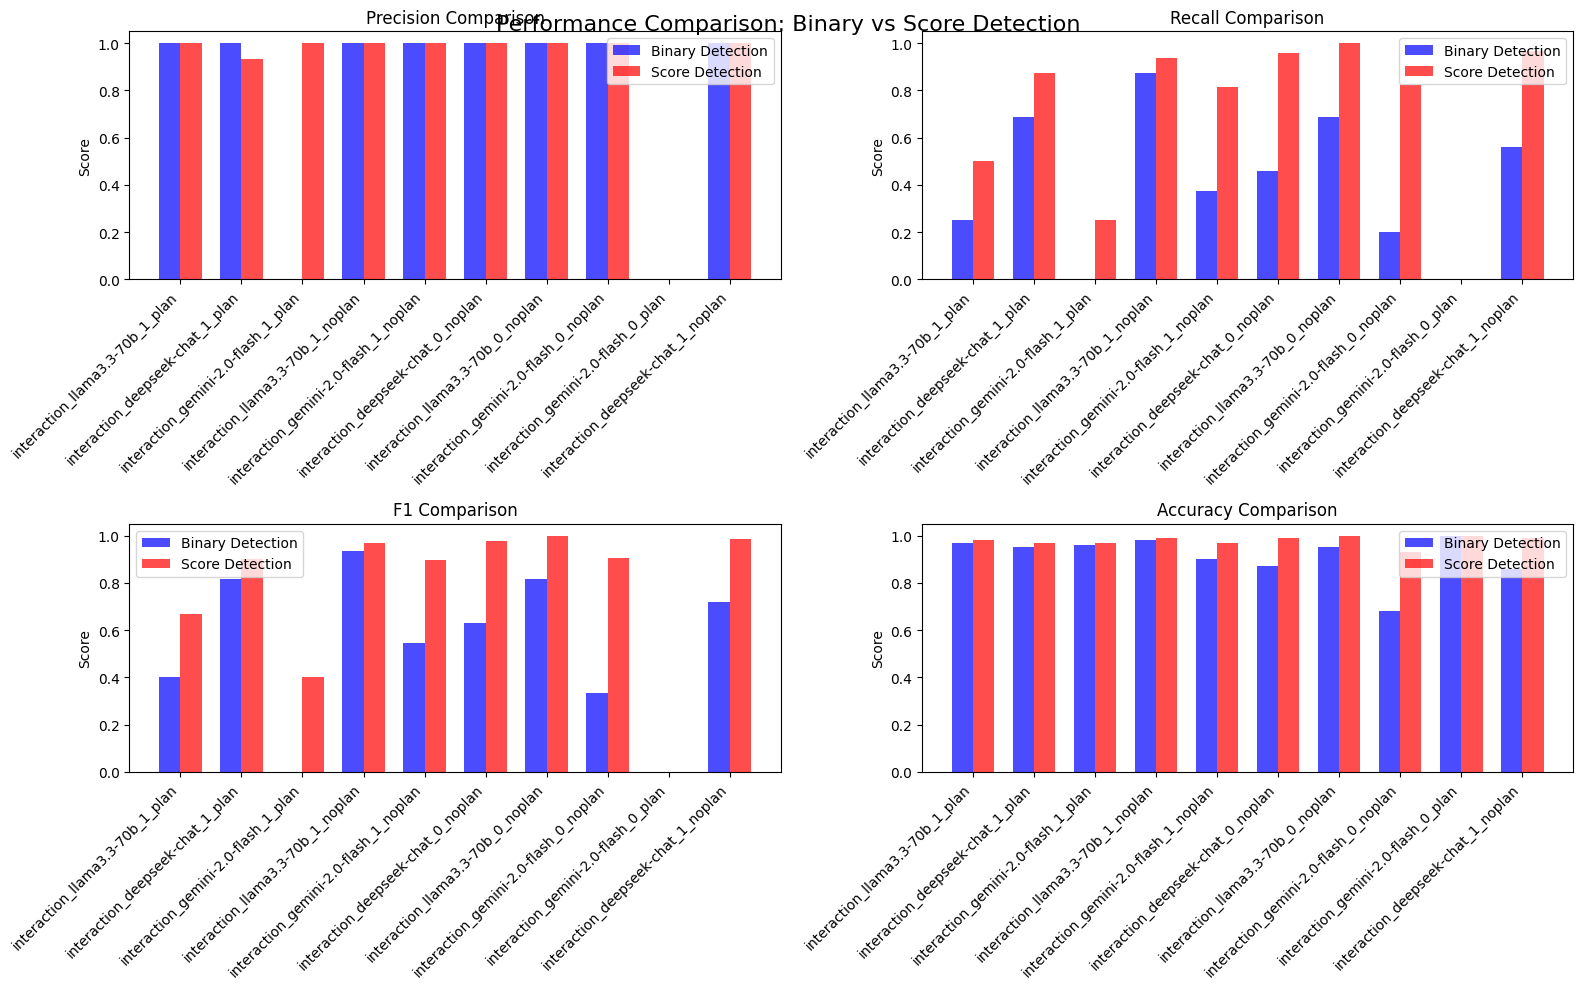

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance_comparison(binary_metrics_df, score_metrics_df):
    """
    Create a comprehensive visualization comparing binary and score detection performance.
    
    Args:
        binary_metrics_df (pd.DataFrame): DataFrame with binary detection metrics
        score_metrics_df (pd.DataFrame): DataFrame with score detection metrics
    """
    plt.figure(figsize=(16, 10))
    
    # Metrics to plot
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    
    # Create subplots
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        
        # Bar plot for each dataset
        binary_values = binary_metrics_df[metric]
        score_values = score_metrics_df[metric]
        
        x = range(len(binary_values))
        width = 0.35
        
        plt.bar([xi - width/2 for xi in x], binary_values, width, label='Binary Detection', color='blue', alpha=0.7)
        plt.bar([xi + width/2 for xi in x], score_values, width, label='Score Detection', color='red', alpha=0.7)
        
        plt.title(f'{metric} Comparison')
        plt.ylabel('Score')
        plt.xticks(x, dataset_names, rotation=45, ha='right')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Performance Comparison: Binary vs Score Detection', fontsize=16)
    plt.show()



# After computing metrics and confusion matrices
plot_performance_comparison(binary_metrics_df, score_metrics_df)

In [ ]:
binary_detection_results = pd.concat([binary_confusion_df, binary_metrics_df], axis=1)

print(binary_detection_results)
    

                                                    TP  FP  FN   TN  \
llama3.3-70b_1_interactions_plan_detection_resu...   1   0   3   96   
deepseek-chat_1_interactions_plan_detection_res...  11   0   5   84   
gemini-2.0-flash_1_interactions_plan_detection_...   0   0   4   96   
llama3.3-70b_1_interactions_noplan_detection_re...  14   0   2   84   
gemini-2.0-flash_1_interactions_noplan_detectio...   6   0  10   84   
deepseek-chat_0_interactions_noplan_detection_r...  11   0  13   76   
llama3.3-70b_0_interactions_noplan_detection_re...  11   0   5   84   
gemini-2.0-flash_0_interactions_noplan_detectio...   8   0  32   60   
gemini-2.0-flash_0_interactions_plan_detection_...   0   0   0  100   
deepseek-chat_1_interactions_noplan_detection_r...  18   0  14   68   

                                                    Precision    Recall  \
llama3.3-70b_1_interactions_plan_detection_resu...        1.0  0.250000   
deepseek-chat_1_interactions_plan_detection_res...        1.0  0.687

In [ ]:
score_detection_results = pd.concat([score_confusion_df, score_metrics_df], axis=1)

print(score_detection_results)

                                                    TP  FP  FN   TN  \
llama3.3-70b_1_interactions_plan_detection_resu...   2   0   2   96   
deepseek-chat_1_interactions_plan_detection_res...  14   1   2   83   
gemini-2.0-flash_1_interactions_plan_detection_...   1   0   3   96   
llama3.3-70b_1_interactions_noplan_detection_re...  15   0   1   84   
gemini-2.0-flash_1_interactions_noplan_detectio...  13   0   3   84   
deepseek-chat_0_interactions_noplan_detection_r...  23   0   1   76   
llama3.3-70b_0_interactions_noplan_detection_re...  16   0   0   84   
gemini-2.0-flash_0_interactions_noplan_detectio...  33   0   7   60   
gemini-2.0-flash_0_interactions_plan_detection_...   0   0   0  100   
deepseek-chat_1_interactions_noplan_detection_r...  31   0   1   68   

                                                    Precision    Recall  \
llama3.3-70b_1_interactions_plan_detection_resu...   1.000000  0.500000   
deepseek-chat_1_interactions_plan_detection_res...   0.933333  0.875

In [ ]:
binary_metrics_df

,Precision,Recall,F1,Accuracy
llama3.3-70b_1_interactions_plan_detection_results.json,1.0,0.250000,0.400000,0.97
deepseek-chat_1_interactions_plan_detection_results.json,1.0,0.687500,0.814815,0.95
gemini-2.0-flash_1_interactions_plan_detection_results.json,0.0,0.000000,0.000000,0.96
llama3.3-70b_1_interactions_noplan_detection_results.json,1.0,0.875000,0.933333,0.98
gemini-2.0-flash_1_interactions_noplan_detection_results.json,1.0,0.375000,0.545455,0.90
deepseek-chat_0_interactions_noplan_detection_results.json,1.0,0.458333,0.628571,0.87
llama3.3-70b_0_interactions_noplan_detection_results.json,1.0,0.687500,0.814815,0.95
gemini-2.0-flash_0_interactions_noplan_detection_results.json,1.0,0.200000,0.333333,0.68
gemini-2.0-flash_0_interactions_plan_detection_results.json,0.0,0.000000,0.000000,1.00
deepseek-chat_1_interactions_noplan_detection_results.json,1.0,0.562500,0.720000,0.86


In [ ]:
# Combine score_metrics_df and score_confusion_df
score_detection_df = pd.concat([score_metrics_df, score_confusion_df], axis=1)
print(score_detection_df)

                                                    Precision    Recall  \
llama3.3-70b_1_interactions_plan_detection_resu...   1.000000  0.500000   
deepseek-chat_1_interactions_plan_detection_res...   0.933333  0.875000   
gemini-2.0-flash_1_interactions_plan_detection_...   1.000000  0.250000   
llama3.3-70b_1_interactions_noplan_detection_re...   1.000000  0.937500   
gemini-2.0-flash_1_interactions_noplan_detectio...   1.000000  0.812500   
deepseek-chat_0_interactions_noplan_detection_r...   1.000000  0.958333   
llama3.3-70b_0_interactions_noplan_detection_re...   1.000000  1.000000   
gemini-2.0-flash_0_interactions_noplan_detectio...   1.000000  0.825000   
gemini-2.0-flash_0_interactions_plan_detection_...   0.000000  0.000000   
deepseek-chat_1_interactions_noplan_detection_r...   1.000000  0.968750   

                                                          F1  Accuracy  TP  \
llama3.3-70b_1_interactions_plan_detection_resu...  0.666667      0.98   2   
deepseek-chat_1_in

In [ ]:
import numpy as np
from scipy import stats

# Assuming you have already calculated metrics for binary and score detection
def statistical_significance_test(binary_metrics, score_metrics):
    """
    Perform statistical significance tests on different performance metrics.
    
    Args:
        binary_metrics (dict): Performance metrics for binary detection
        score_metrics (dict): Performance metrics for score detection
    
    Returns:
        dict: p-values for each metric
    """
    significance_results = {}
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    
    for metric in metrics:
        # Perform paired t-test
        t_statistic, p_value = stats.ttest_rel(
            binary_metrics[metric], 
            score_metrics[metric]
        )
        
        significance_results[metric] = {
            't_statistic': t_statistic,
            'p_value': p_value,
            'is_significant': p_value < 0.05
        }
    
    return significance_results

In [ ]:
binary_metrics_df.mean()

Precision    0.800000
Recall       0.409583
F1           0.519032
Accuracy     0.912000
dtype: float64

In [ ]:
score_metrics_df.mean()

Precision    0.893333
Recall       0.712708
F1           0.770115
Accuracy     0.979000
dtype: float64

In [ ]:
significance_results = statistical_significance_test(binary_metrics_df, score_metrics_df)

In [ ]:
# Print significance results
for metric, result in significance_results.items():
    print(f"{metric.capitalize()} Test:")
    print(f"  t-statistic: {result['t_statistic']}")
    print(f"  p-value: {result['p_value']}")
    print(f"  Statistically Significant: {result['is_significant']}\n")


Precision Test:
  t-statistic: -0.9244734516419052
  p-value: 0.3793596770460118
  Statistically Significant: False

Recall Test:
  t-statistic: -4.932203389830508
  p-value: 0.0008108802695115192
  Statistically Significant: True

F1 Test:
  t-statistic: -4.458678566327645
  p-value: 0.0015802667733757878
  Statistically Significant: True

Accuracy Test:
  t-statistic: -2.662076532456444
  p-value: 0.025957310638157947
  Statistically Significant: True

